# Oregon Wildlife - Image Classification Capstone - Baseline Modeling
## David Lappin
### BrainStation
#### 3/1/2023 -

Packages Import:

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL 
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Import Data:

In [5]:
#set local path to files for basic exploration

datapath = 'data/oregon_wildlife/' # This is the relative path to the data
image_files = os.listdir(datapath) #these are the individual folder names (the class names)

Ensure Data is still in the same state as we left it from the previous EDA before modeling.

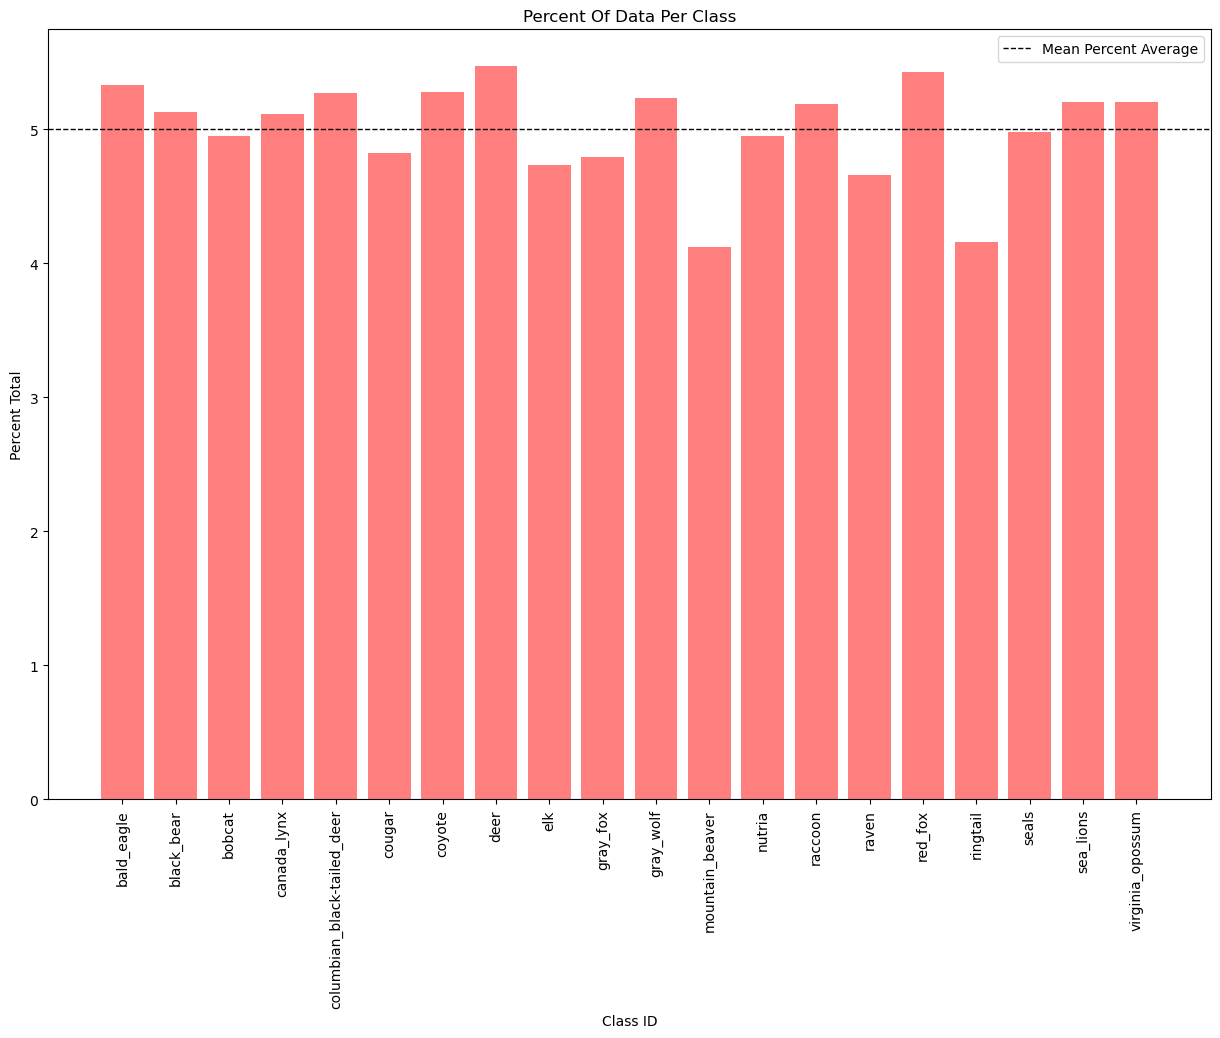

In [8]:
#create list of the class name and counts

totalcount = []
class_for_count = []

for file in image_files:
    
    count = len(list(glob(f'data/oregon_wildlife/{file}/*')))
    totalcount.append(count)
    class_for_count.append(file)
    
    #print(f'{count}: {file}')

#creates simple dataframe for the class counts in the dataset

classcounts = pd.DataFrame(list(zip(class_for_count, totalcount)), #zip the two lists together from above
                 columns=['class_id','count']) #Assign column names

#add percent total to df

classcounts['pct_total'] = round(classcounts['count']/(classcounts['count'].sum())*100, 2)

#plot the percent total for each class in the data

plt.figure(figsize = (15, 10))

plt.bar(classcounts['class_id'], classcounts['pct_total'], color = 'red', alpha = 0.5)
plt.title('percent of data per class'.title())
plt.xlabel('Class ID')
plt.ylabel('Percent Total')

plt.axhline(5, color = 'black', linestyle = '--', linewidth = 1, label = 'Mean Percent Average')
plt.xticks(rotation = 90)
plt.legend()
plt.show()

Everything looks the same. The data is mostly balanced with no significant outliers. We can move on to splitting and modelling the data.

# Split data:

In [34]:
#define loading parameters 

batch_size = 32 #use batch size of 32 images 
img_height = 180 
img_width = 180


For now we are goin to leave the hieght and widgth at 180x180. If we need to reduce the complexity of the photos later for modeling we can reduce these values.

In [67]:
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  datapath,
  validation_split=0.2,
  subset="training",
  label_mode='int',
  seed=7,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13950 files belonging to 20 classes.
Using 11160 files for training.


In [68]:
val_set = tf.keras.preprocessing.image_dataset_from_directory(
  datapath,
  validation_split=0.2,
  subset="validation",
  label_mode='int',
  seed=7,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13950 files belonging to 20 classes.
Using 2790 files for validation.


### Reference:

Code below on how to create a test set when one does not exist from:

https://www.tensorflow.org/tutorials/images/transfer_learning


From the TF tutorial they exaplain that you can determine the number of batches in the training set as we defined above using the cardinality. From the amount of batches we can then siphon of 'X' amount or percent to create and save a test set. 

In [69]:
#create a test set

val_batches = tf.data.experimental.cardinality(val_set) #total number of batches in train_set
test_set = val_set.take(val_batches // 10)  #test set is total number divided by 10
val_sd = val_set.skip(val_batches // 10)    #remainder of the above division remains in the validation set

In [70]:
print(f'Number of validation batches: {tf.data.experimental.cardinality(val_set)}')
print(f'Number of test batches: {tf.data.experimental.cardinality(test_set)}')


Number of validation batches: 88
Number of test batches: 8


In [71]:
test_set

<TakeDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Note that the `test_set` is a "TakeDataset" type. I am not able to access class_names as I was in the test/train set, but we will still be able to use this to make predictions from our later modelling. 

# Create and Compile Baseline Model

Similar to our preliminary compatibility testing in the EDA section we are going to create a simple Convolutional Neural Network (CNN) based in TF/Keras for our baseline model.

In [74]:
#save and check class_names in the training set

class_names = train_set.class_names
len(class_names)


20

Below:
- **Autotune** allows for CPU performance optimizaiton
- **Cache** - stores imported images in memory for future epoch iterations
- **prefetch** - allows for overlapping of preprocess and training

In [ ]:
#adjust the prefetching for performance

AUTOTUNE = tf.data.AUTOTUNE #Autotune optimizes CPU uptime for each batch

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) #cache stores data in memory after 1st epoch for faster iterations
val_set = val_set.cache().prefetch(buffer_size=AUTOTUNE) #prefetch allows for overlapping 
test_set = test_set.prefetch(buffer_size=AUTOTUNE)


A basic CNN including three convolutions and Maxpooling layers, one dense layer and an output layer equal to the number of classes present in the data (20).

**NOTE:** Per Tensorflow guidance: "This model has not been tuned for high accuracy". This model construction will serve as a basic baseline to build off of.

In [75]:
#build model 

num_classes = len(class_names) # define the number of classes

#define model sequential
model = Sequential([
 
  #include rescaling layer directly in model build  
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  
  #include the convolution blocks with max pooling layers, and 'relu' activation  
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  #flatten   
  layers.Flatten(),
    
  #dense layer (single) with relu activation  
  layers.Dense(128, activation='relu'),
    
  #output later with num_classes (20)   
  layers.Dense(num_classes)
])


Compile the model using:
- Adam Optimzer (high performing gradient decent method, default learning rate = 0.001)
 - note there are other options but we will stick with Adam
- SparseCategoricalCrossentropy loss calcualtion  (used when there are more than two classes or labels)

In [76]:
#compile the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [77]:
#look at the compiled model summary 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In our baseline model we have now compiled all the layers. There are ~4million trainable parameters, and we see our output layer is 20 which matches our class labels. 

Next we can fit our model to the training data using 10 epochs. Our model will be validated on the validation split. The test set will be saved for predictions later. 

In [78]:
#fit model for 10 epochs

epochs = 10

history = model.fit(   
  train_set,            
  validation_data=val_set, 
  epochs=epochs            
)

Epoch 1/10
349/349 [==============================] - 131s 370ms/step - loss: 2.5640 - accuracy: 0.2155 - val_loss: 2.2258 - val_accuracy: 0.3183
Epoch 2/10
349/349 [==============================] - 133s 379ms/step - loss: 1.6445 - accuracy: 0.5179 - val_loss: 1.6645 - val_accuracy: 0.5412
Epoch 3/10
349/349 [==============================] - 131s 374ms/step - loss: 0.7375 - accuracy: 0.7925 - val_loss: 1.3531 - val_accuracy: 0.6978
Epoch 4/10
349/349 [==============================] - 130s 371ms/step - loss: 0.2779 - accuracy: 0.9242 - val_loss: 1.5618 - val_accuracy: 0.7315
Epoch 5/10
349/349 [==============================] - 131s 373ms/step - loss: 0.1405 - accuracy: 0.9652 - val_loss: 1.4818 - val_accuracy: 0.7882
Epoch 6/10
349/349 [==============================] - 134s 381ms/step - loss: 0.0959 - accuracy: 0.9811 - val_loss: 1.5240 - val_accuracy: 0.7946
Epoch 7/10
349/349 [==============================] - 133s 378ms/step - loss: 0.0842 - accuracy: 0.9813 - val_loss: 1.6796 -

Save the model:

In [79]:
#save the model weights for use in predictions later if desired

model.save('Baseline_Actual10.h5')

#### Observations:

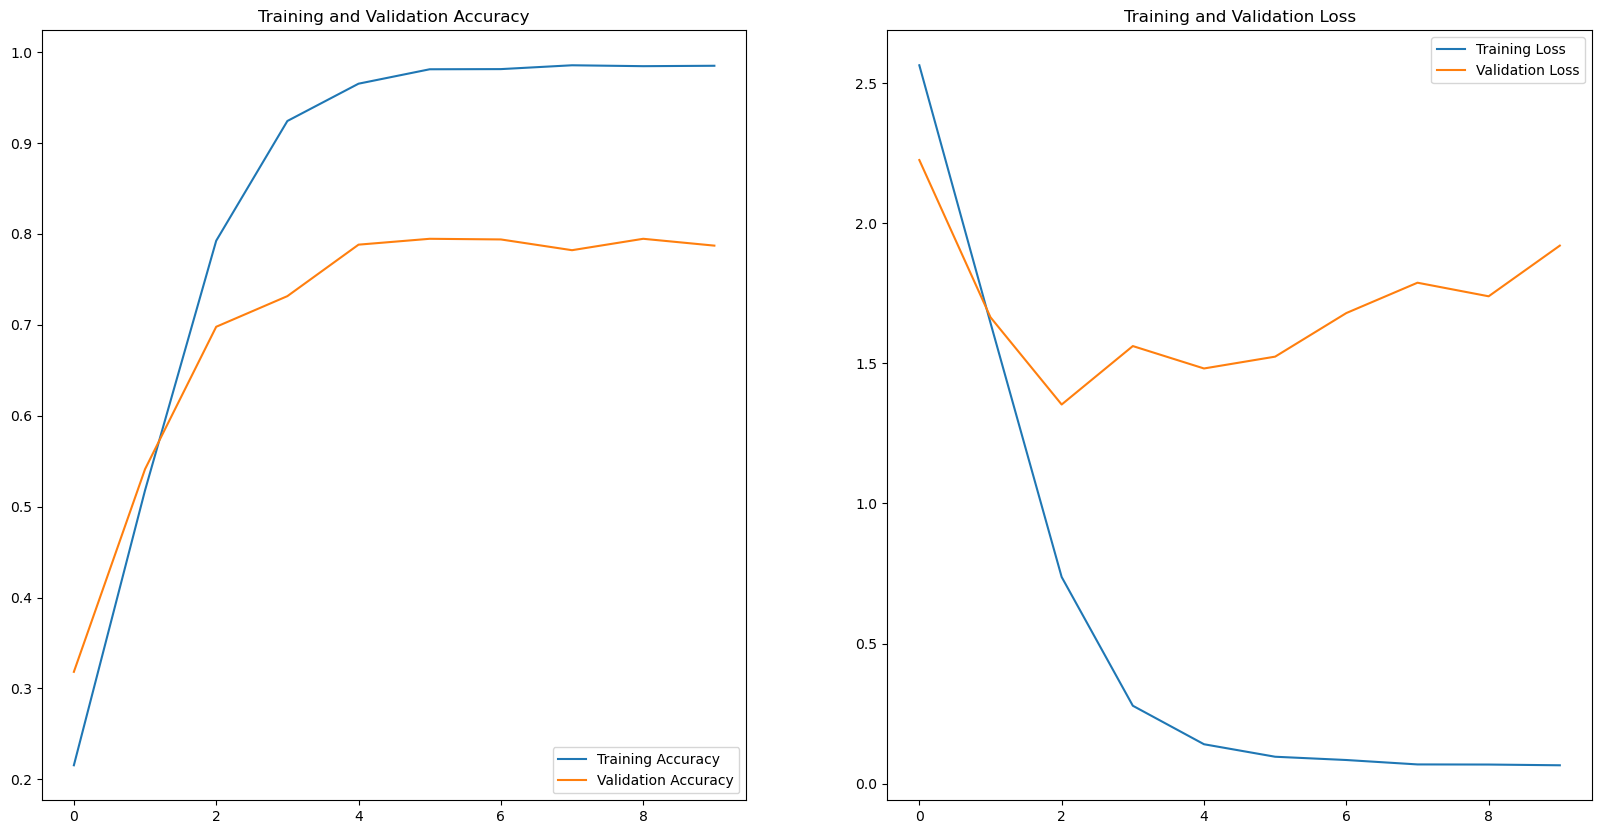

In [86]:
#visualize model performance (plots code ref from TF guide)


#pull out the accuracy and validation accuracies from model fit history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#pull out the loss data from the model fit history
loss = history.history['loss']
val_loss = history.history['val_loss']

#x lab range defined by the # of epochs ran
epochs_range = range(epochs)

#trainig vs Validation Accuracies
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#visualize loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [164]:
predictions = model.predict(test_set)
score = tf.nn.softmax(predictions[30])


8/8 [==============================] - 2s 112ms/step


In [165]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to seals with a 99.98 percent confidence.


In [161]:
test_set.batch

<bound method DatasetV2.batch of <TakeDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>>

TypeError: 'TakeDataset' object is not subscriptable

In [144]:
predictions = np.array([])
labels = np.array([])
for x, y in test_set:
    predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=1)])
    labels = np.concatenate([labels, y.numpy()])
    #print('predict= ', predictions, 'label= ', labels)
con_mat = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
con_mat_norm = np.around(con_mat.astype('float')/con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm, index=class_names, columns=class_names)

1/1 [==============================] - 0s 69ms/step


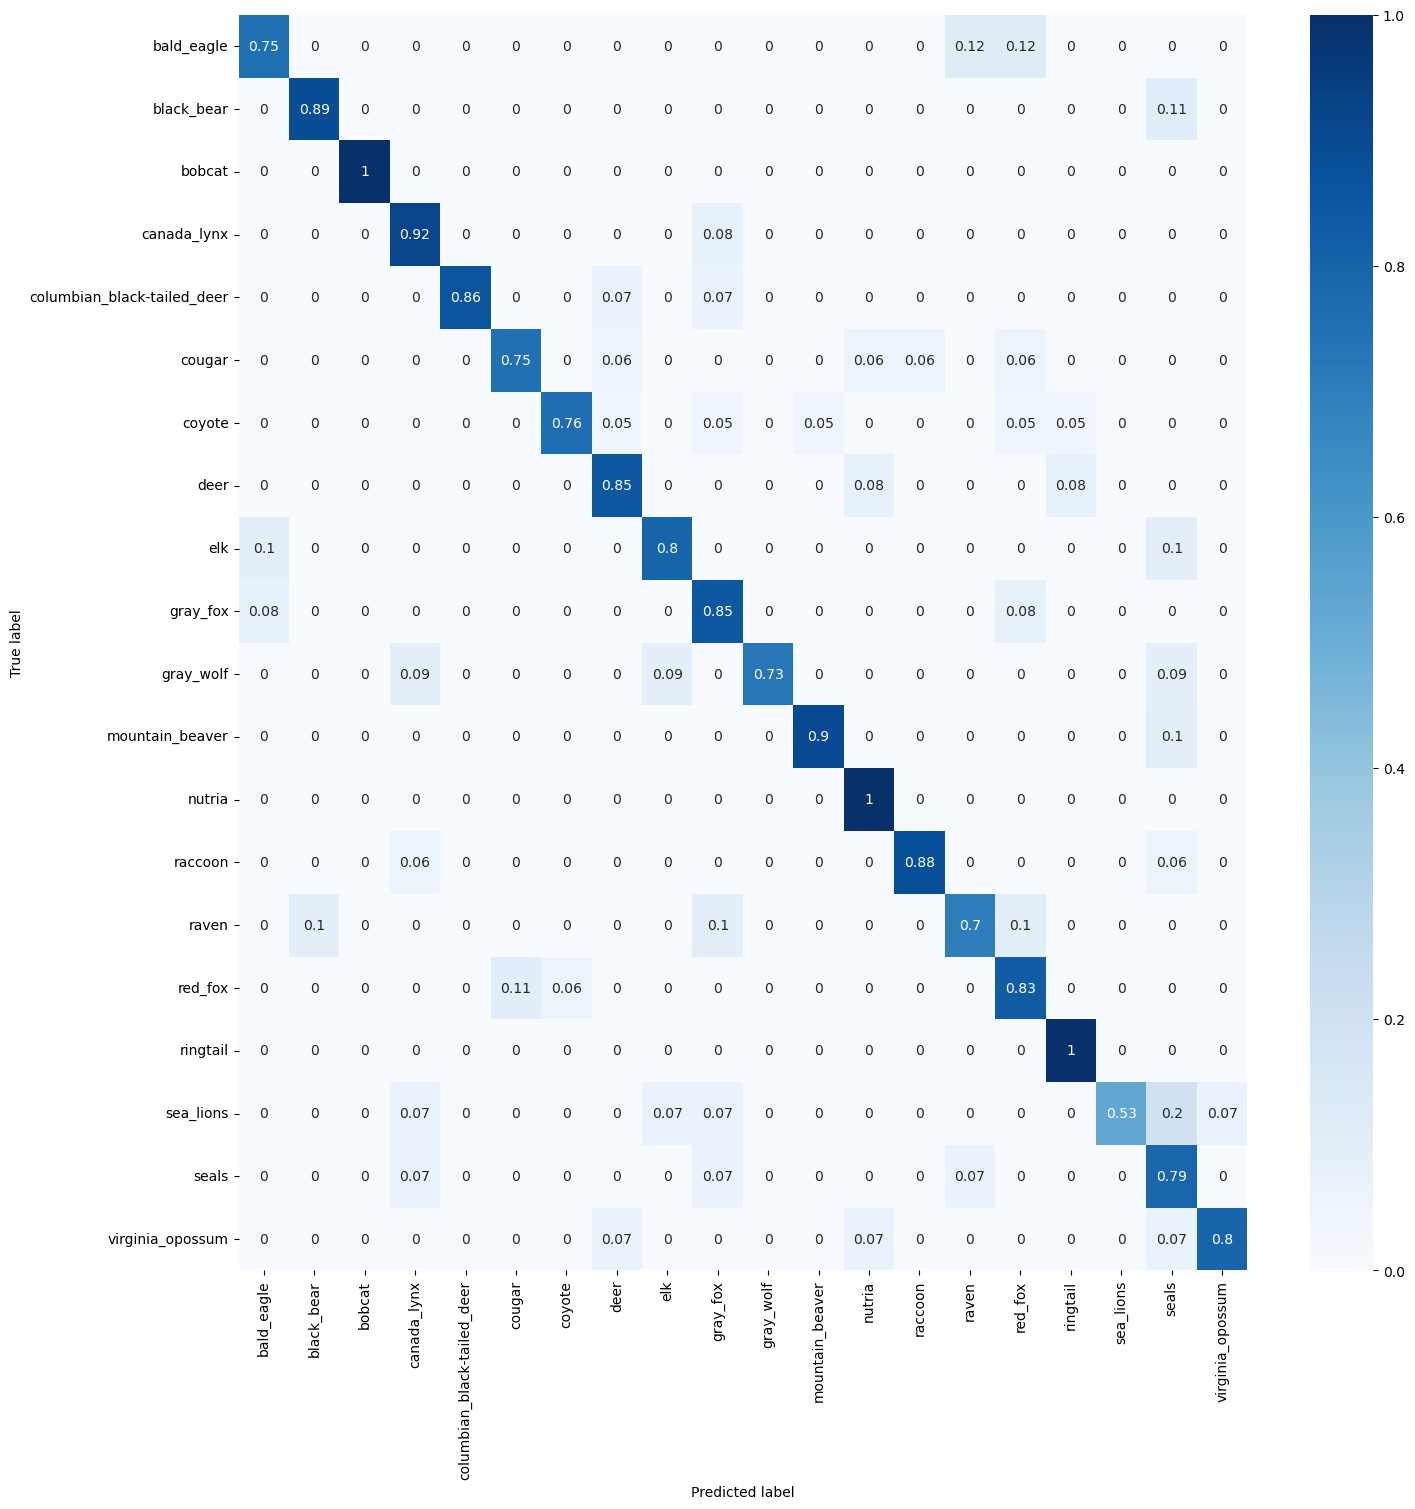

In [145]:
import seaborn as sns
figure = plt.figure(figsize=(15,15))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



In [166]:
train_set.class_names


['bald_eagle',
 'black_bear',
 'bobcat',
 'canada_lynx',
 'columbian_black-tailed_deer',
 'cougar',
 'coyote',
 'deer',
 'elk',
 'gray_fox',
 'gray_wolf',
 'mountain_beaver',
 'nutria',
 'raccoon',
 'raven',
 'red_fox',
 'ringtail',
 'sea_lions',
 'seals',
 'virginia_opossum']